In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pathlib
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
!unzip /content/spaceship-titanic.zip

Archive:  /content/spaceship-titanic.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### In this section, the train and test dataset is read first.

In [ ]:
df_test = pd.read_csv("test.csv")
df_test.drop(['Name', 'PassengerId'], axis=1, inplace=True)
df_train = pd.read_csv("train.csv")
df_train.drop(['Name', 'PassengerId'], axis=1, inplace=True)
df_train

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False


### The dimension of the training and test data is shown. We have 13 features in this dataset.

In [ ]:
print(df_train.shape, df_test.shape)

(8693, 12) (4277, 11)


### There are no duplicate rows and the shape of the data has not changed.

In [ ]:
df_train.drop_duplicates().shape

(8678, 12)

### Also, from the sum of RoomService, FoodCourt and ShoppingMall variables, the total expenses can be calculated and considered as a new variable.

In [ ]:
df_train['total_spending'] = df_train['RoomService'] + df_train['FoodCourt'] + df_train['ShoppingMall'] +\
df_train['Spa'] + df_train['VRDeck']


### Converting the cabin variable to 3 variables due to the importance of information.

In [ ]:
df_train[["Cabin_Deck", "Cabin_num", "Cabin_Side"]] = df_train["Cabin"].str.split("/", expand=True)
try:
    df_train = df_train.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")


In [ ]:
df_train.head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,total_spending,Cabin_Deck,Cabin_num,Cabin_Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,736.0,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,10383.0,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,5176.0,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1091.0,F,1,S
5,Earth,False,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True,774.0,F,0,P
6,Earth,False,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True,1584.0,F,2,S
7,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,True,NaN,G,0,S
8,Earth,False,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True,1018.0,F,3,S
9,Europa,True,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True,0.0,B,1,P


### At this stage, we have an overview of a type of dataset features

In [ ]:
df_train.dtypes

HomePlanet         object
CryoSleep          object
Destination        object
Age               float64
VIP                object
RoomService       float64
FoodCourt         float64
ShoppingMall      float64
Spa               float64
VRDeck            float64
Transported          bool
total_spending    float64
Cabin_Deck         object
Cabin_num          object
Cabin_Side         object
dtype: object

### In the next two cells, we separate qualitative and quantitative variables from each other.

In [ ]:
print("Categorical Variables : ")
categorical_variables = df_train.select_dtypes(include=['object', 'bool']).columns
for col in categorical_variables:
    print(col)

Categorical Variables : 
HomePlanet
CryoSleep
Destination
VIP
Transported
Cabin_Deck
Cabin_num
Cabin_Side


In [ ]:
df_train['Transported'] = df_train['Transported'].astype(object)
print(df_train.dtypes)

HomePlanet         object
CryoSleep          object
Destination        object
Age               float64
VIP                object
RoomService       float64
FoodCourt         float64
ShoppingMall      float64
Spa               float64
VRDeck            float64
Transported        object
total_spending    float64
Cabin_Deck         object
Cabin_num          object
Cabin_Side         object
dtype: object


In [ ]:
print("Numerical Variables : ")
numerical_variables = df_train._get_numeric_data().columns
for col in numerical_variables:
    print(col)

Numerical Variables : 
Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck
total_spending


### In the output of this code, we can see what range of values ​​each quantitative and qualitative variable of the data set is in.

In [ ]:
unique_values = {col:df_train[col].unique()[:30] for col in df_train.columns}
for col, values in unique_values.items():
    print(f"{col}: {values}")

HomePlanet: ['Europa' 'Earth' 'Mars' nan]
CryoSleep: [False True nan]
Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Age: [39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23.]
VIP: [False True nan]
RoomService: [0.000e+00 1.090e+02 4.300e+01 3.030e+02 4.200e+01 3.900e+01 7.300e+01
 7.190e+02 8.000e+00 3.200e+01 1.286e+03 4.120e+02       nan 9.800e+02
 2.200e+01 1.125e+03 2.140e+02 7.840e+02 5.540e+02 9.700e+02 7.900e+02
 4.000e+00 2.790e+02 4.500e+01 1.000e+00 1.946e+03 7.930e+02 8.870e+02
 1.900e+02 1.600e+01]
FoodCourt: [0.000e+00 9.000e+00 3.576e+03 1.283e+03 7.000e+01 4.830e+02 1.539e+03
 7.850e+02 7.295e+03 1.000e+00 9.740e+02 1.220e+02 2.000e+00 2.250e+02
 6.073e+03 8.500e+02 9.640e+02 4.920e+02 1.950e+02 1.640e+02 1.120e+02
 6.050e+02 1.096e+03 5.920e+02 1.530e+02 2.580e+02 3.700e+01 2.165e+03
 8.300e+01 8.397e+03]
ShoppingMall: [0.000e+00 2.500e+01 3.710e+02 1.510e+02 3.000e+00 1.700e+01       

### In the code below, a specific and unique value is specified for each feature.

In [ ]:
df_train.nunique()

HomePlanet           3
CryoSleep            2
Destination          3
Age                 80
VIP                  2
RoomService       1273
FoodCourt         1507
ShoppingMall      1115
Spa               1327
VRDeck            1306
Transported          2
total_spending    2116
Cabin_Deck           8
Cabin_num         1817
Cabin_Side           2
dtype: int64

### You can see how much missing data there is for each variable. It can be seen how much missing data there is for each variable, and according to the output, we use imputation methods, and due to their large number, these missing data cannot be removed.

In [ ]:
df_train.isnull().sum()

HomePlanet        201
CryoSleep         217
Destination       182
Age               179
VIP               203
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Transported         0
total_spending    908
Cabin_Deck        199
Cabin_num         199
Cabin_Side        199
dtype: int64

### In the next step, by separating the qualitative and quantitative data, we get the descriptive statistics of the data, including information of centrality and dispersion of each feature.

In [ ]:
numeric_descriptive_statistics = df_train.select_dtypes(include='number').describe()
numeric_descriptive_statistics

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spending
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,7785.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,1484.601541
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2845.288241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,736.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1486.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


In [ ]:
df_train.describe(include=['O'])

,HomePlanet,CryoSleep,Destination,VIP,Transported,Cabin_Deck,Cabin_num,Cabin_Side
count,8492,8476,8511,8490,8693,8494,8494,8494
unique,3,2,3,2,2,8,1817,2
top,Earth,False,TRAPPIST-1e,False,True,F,82,S
freq,4602,5439,5915,8291,4378,2794,28,4288


# Visualize data

### According to bar, histogram and pie charts, you can see how the data is scattered in each feature. For example, for the age variable, it can be seen that it follows a normal distribution despite some skewness, but other variables have a huge skewness and the abundance of data is only focused on a specific range.

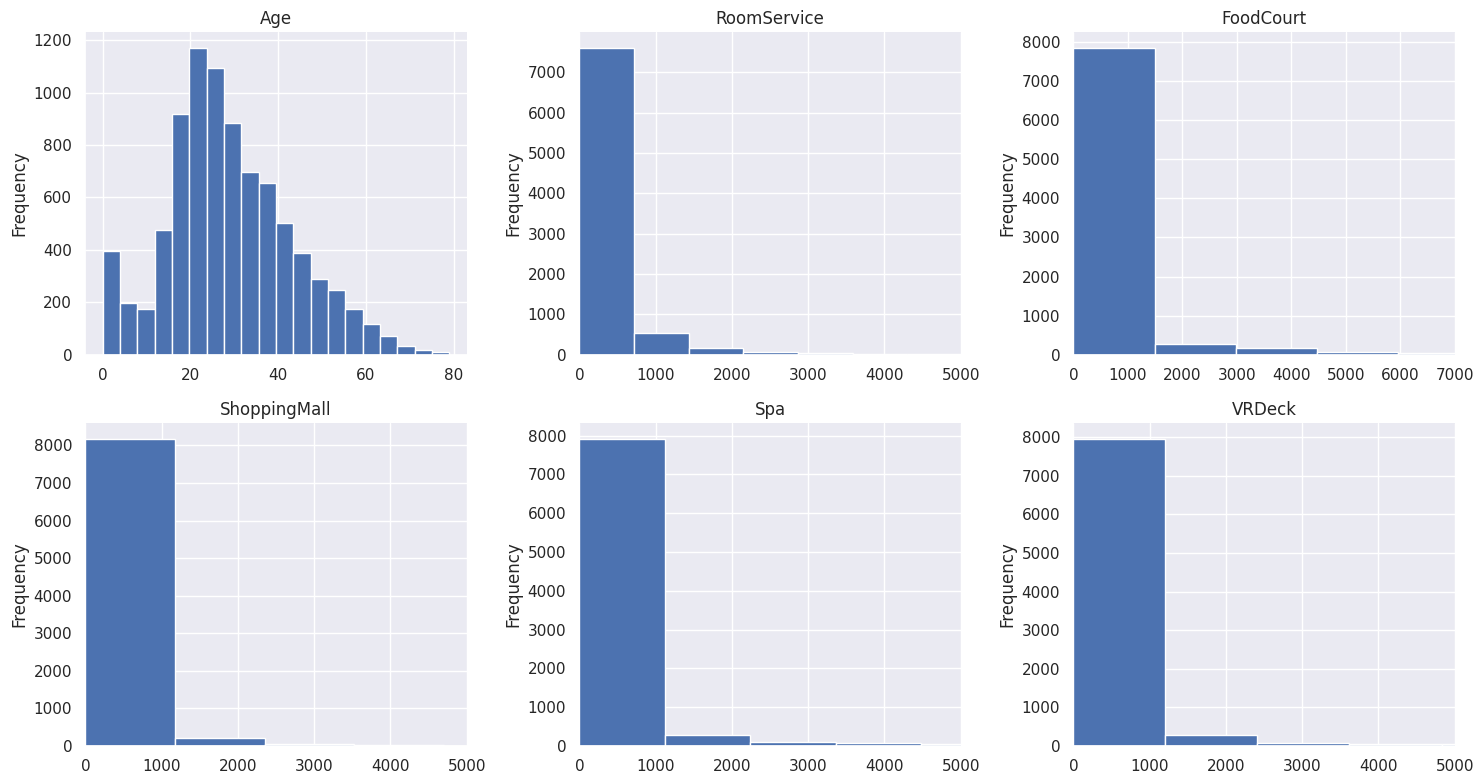

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
df_train['Age'].plot(kind='hist', bins=20, title='Age', ax=axs[0, 0])
df_train['RoomService'].plot(kind='hist', bins=20, title='RoomService', ax=axs[0, 1])
df_train['FoodCourt'].plot(kind='hist', bins=20, title='FoodCourt', ax=axs[0, 2])
df_train['ShoppingMall'].plot(kind='hist', bins=20, title='ShoppingMall', ax=axs[1, 0])
df_train['Spa'].plot(kind='hist', bins=20, title='Spa', ax=axs[1, 1])
df_train['VRDeck'].plot(kind='hist', bins=20, title='VRDeck', ax=axs[1, 2])


axs[0, 1].set_xlim(0, 5000)
axs[0,2].set_xlim(0, 7000)
axs[1,0].set_xlim(0, 5000)
axs[1,1].set_xlim(0, 5000)
axs[1,2].set_xlim(0, 5000)

for ax in axs.flatten():
    ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

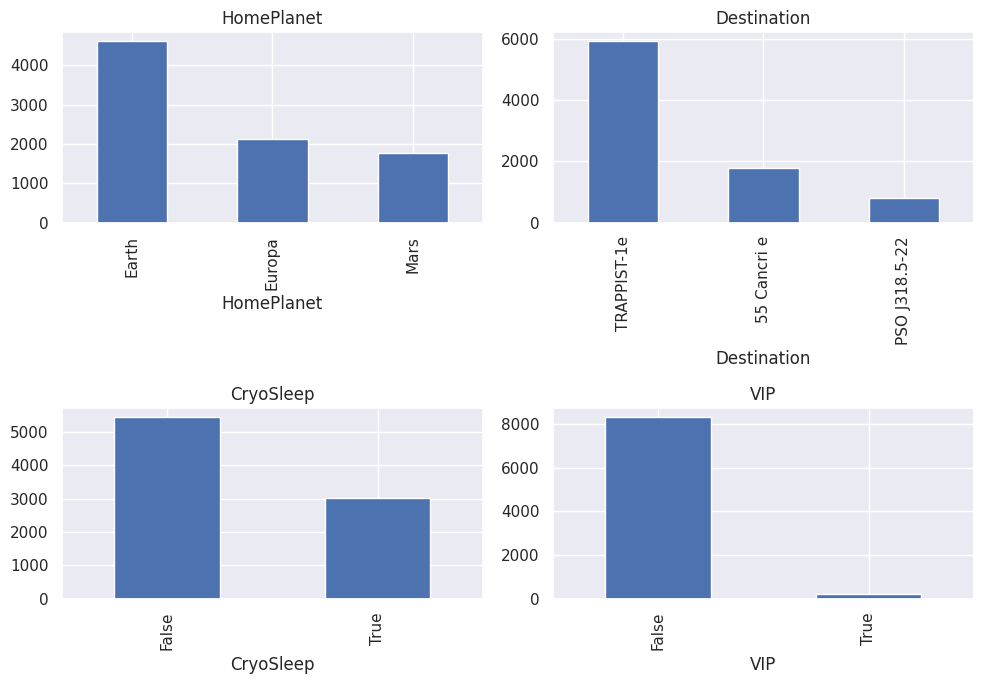

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
df_train['HomePlanet'].value_counts().plot(kind='bar', title='HomePlanet')
plt.subplot(2,2,2)
df_train['Destination'].value_counts().plot(kind='bar', title='Destination')
plt.subplot(2,2,3)
df_train['CryoSleep'].value_counts().plot(kind='bar', title='CryoSleep')
plt.subplot(2,2,4)
df_train['VIP'].value_counts().plot(kind='bar',title='VIP')
plt.tight_layout();

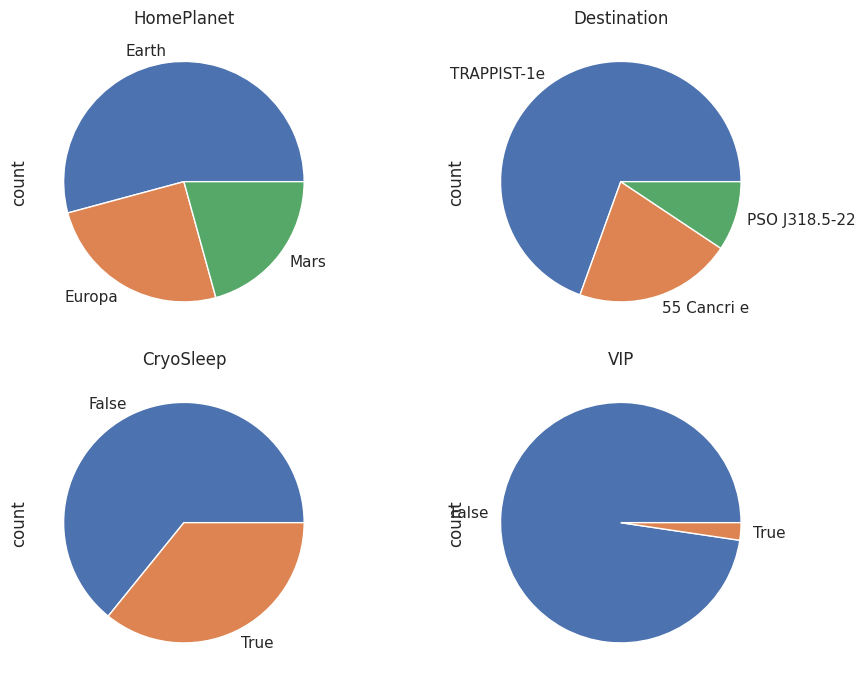

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
df_train['HomePlanet'].value_counts().plot(kind='pie', title='HomePlanet')
plt.subplot(2,2,2)
df_train['Destination'].value_counts().plot(kind='pie', title='Destination')
plt.subplot(2,2,3)
df_train['CryoSleep'].value_counts().plot(kind='pie', title='CryoSleep')
plt.subplot(2,2,4)
df_train['VIP'].value_counts().plot(kind='pie',title='VIP')
plt.tight_layout();

# imputation of missing data

### In this stage, the numerical and qualitative data are analyzed, and this stage includes different methods, for example, these data can be filled with the average or the most frequent data, i.e. mode, according to the dispersion and distribution of the data. Sometimes, regardless of the data distribution, the missing data was randomly filled from the numbers in the same feature.

### At this stage, according to the number of missing data and the data distribution chart (histogram and bar chart) for qualitative data, they have been randomly filled because no specific pattern has been observed in the distribution of these feature classes, although the missing data can impute with mean or mode.

In [ ]:
df_train.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported',
       'total_spending', 'Cabin_Deck', 'Cabin_num', 'Cabin_Side'],
      dtype='object')

In [ ]:
for cat_col in categorical_variables:
        df_train[cat_col] = df_train[cat_col].fillna(df_train[cat_col].mode()[0])

updated_missing_data = df_train[categorical_variables].isnull().sum()
updated_missing_data




HomePlanet     0
CryoSleep      0
Destination    0
VIP            0
Transported    0
Cabin_Deck     0
Cabin_num      0
Cabin_Side     0
dtype: int64

### For the age variable, according to a data distribution and the characteristics of the mean and standard deviation, we randomly generate data from the uniform distribution and add data to the missing data.

In [ ]:
mean_age = df_train["Age"].mean()
std_age = df_train["Age"].std()
is_null = df_train["Age"].isnull().sum()
rand_sample = np.random.uniform(mean_age - std_age, mean_age + std_age, size = is_null)
df_train.loc[df_train['Age'].isna(), 'Age'] = rand_sample

### And for the rest of the continuous variables, because the data accumulation is only in a certain range, the data is not suitable with the mean value, because according to the property of this central index, the mean value is drawn towards the outlier data, so the missing data is replaced with the value We fill the mediane or mode.

In [ ]:
numerical_variables_without_age = numerical_variables.drop(['Age'])

for column in numerical_variables_without_age:
    df_train[column].fillna(df_train[column].mode()[0], inplace=True)

updated_missing_data = df_train[numerical_variables_without_age].isnull().sum()
updated_missing_data


RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
total_spending    0
dtype: int64

# ordinal encoding

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

categories_HomePlanet = [["Earth", "Europa", "Mars"]]
categories_cabin_deck = [['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T']]
categories_cabin_side = [["P", "S"]]
categories_Destination = [['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22']]

encoder_HomePlanet = OrdinalEncoder(categories=categories_HomePlanet, handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)
encoder_cabin_deck = OrdinalEncoder(categories=categories_cabin_deck , handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)
encoder_cabin_side  = OrdinalEncoder(categories=categories_cabin_side , handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)
encoder_Destination  = OrdinalEncoder(categories=categories_Destination , handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)

df_train['HomePlanet'] = encoder_HomePlanet.fit_transform(pd.DataFrame(df_train['HomePlanet']))
df_train['Cabin_Deck'] = encoder_cabin_deck .fit_transform(pd.DataFrame(df_train['Cabin_Deck']))
df_train['Cabin_Side'] = encoder_cabin_side.fit_transform(pd.DataFrame(df_train['Cabin_Side']))
df_train['Destination'] = encoder_Destination.fit_transform(pd.DataFrame(df_train['Destination']))
df_train.head(10)



,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,total_spending,Cabin_Deck,Cabin_num,Cabin_Side
0,1.0,False,0.0,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0,0.0
1,0.0,False,0.0,24.0,False,109.0,9.0,25.0,549.0,44.0,True,736.0,1.0,0,1.0
2,1.0,False,0.0,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,10383.0,2.0,0,1.0
3,1.0,False,0.0,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,5176.0,2.0,0,1.0
4,0.0,False,0.0,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1091.0,1.0,1,1.0
5,0.0,False,2.0,44.0,False,0.0,483.0,0.0,291.0,0.0,True,774.0,1.0,0,0.0
6,0.0,False,0.0,26.0,False,42.0,1539.0,3.0,0.0,0.0,True,1584.0,1.0,2,1.0
7,0.0,True,0.0,28.0,False,0.0,0.0,0.0,0.0,0.0,True,0.0,3.0,0,1.0
8,0.0,False,0.0,35.0,False,0.0,785.0,17.0,216.0,0.0,True,1018.0,1.0,3,1.0
9,1.0,True,1.0,14.0,False,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,1,0.0


In [ ]:
df_train['CryoSleep'] = df_train['CryoSleep'].astype(int)
df_train['VIP'] = df_train['VIP'].astype(int)
df_train['Transported'] = df_train['Transported'].astype(int)
df_train


df_train_0= df_train

# outlier detection

### To check outlier data for each variable, the points that are outside the range (mean-1.5sigma , mean+1.5sigma) are considered as outlier data and these imputed with the average of each feature. In order to better remove these data, the ranges (mean-sigma , mean+sigma) and (mean-3sigma , mean+3sigma) have also been checked, but the mentioned initial range has performed better.

In [ ]:
columns_to_handle_outliers =  ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_spending']

for column in columns_to_handle_outliers:
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR

    # Handlign outilers using capping method
    df_train[column] = np.where(df_train[column] > upper_limit, upper_limit, np.where(df_train[column] < lower_limit, lower_limit, df_train[column]))


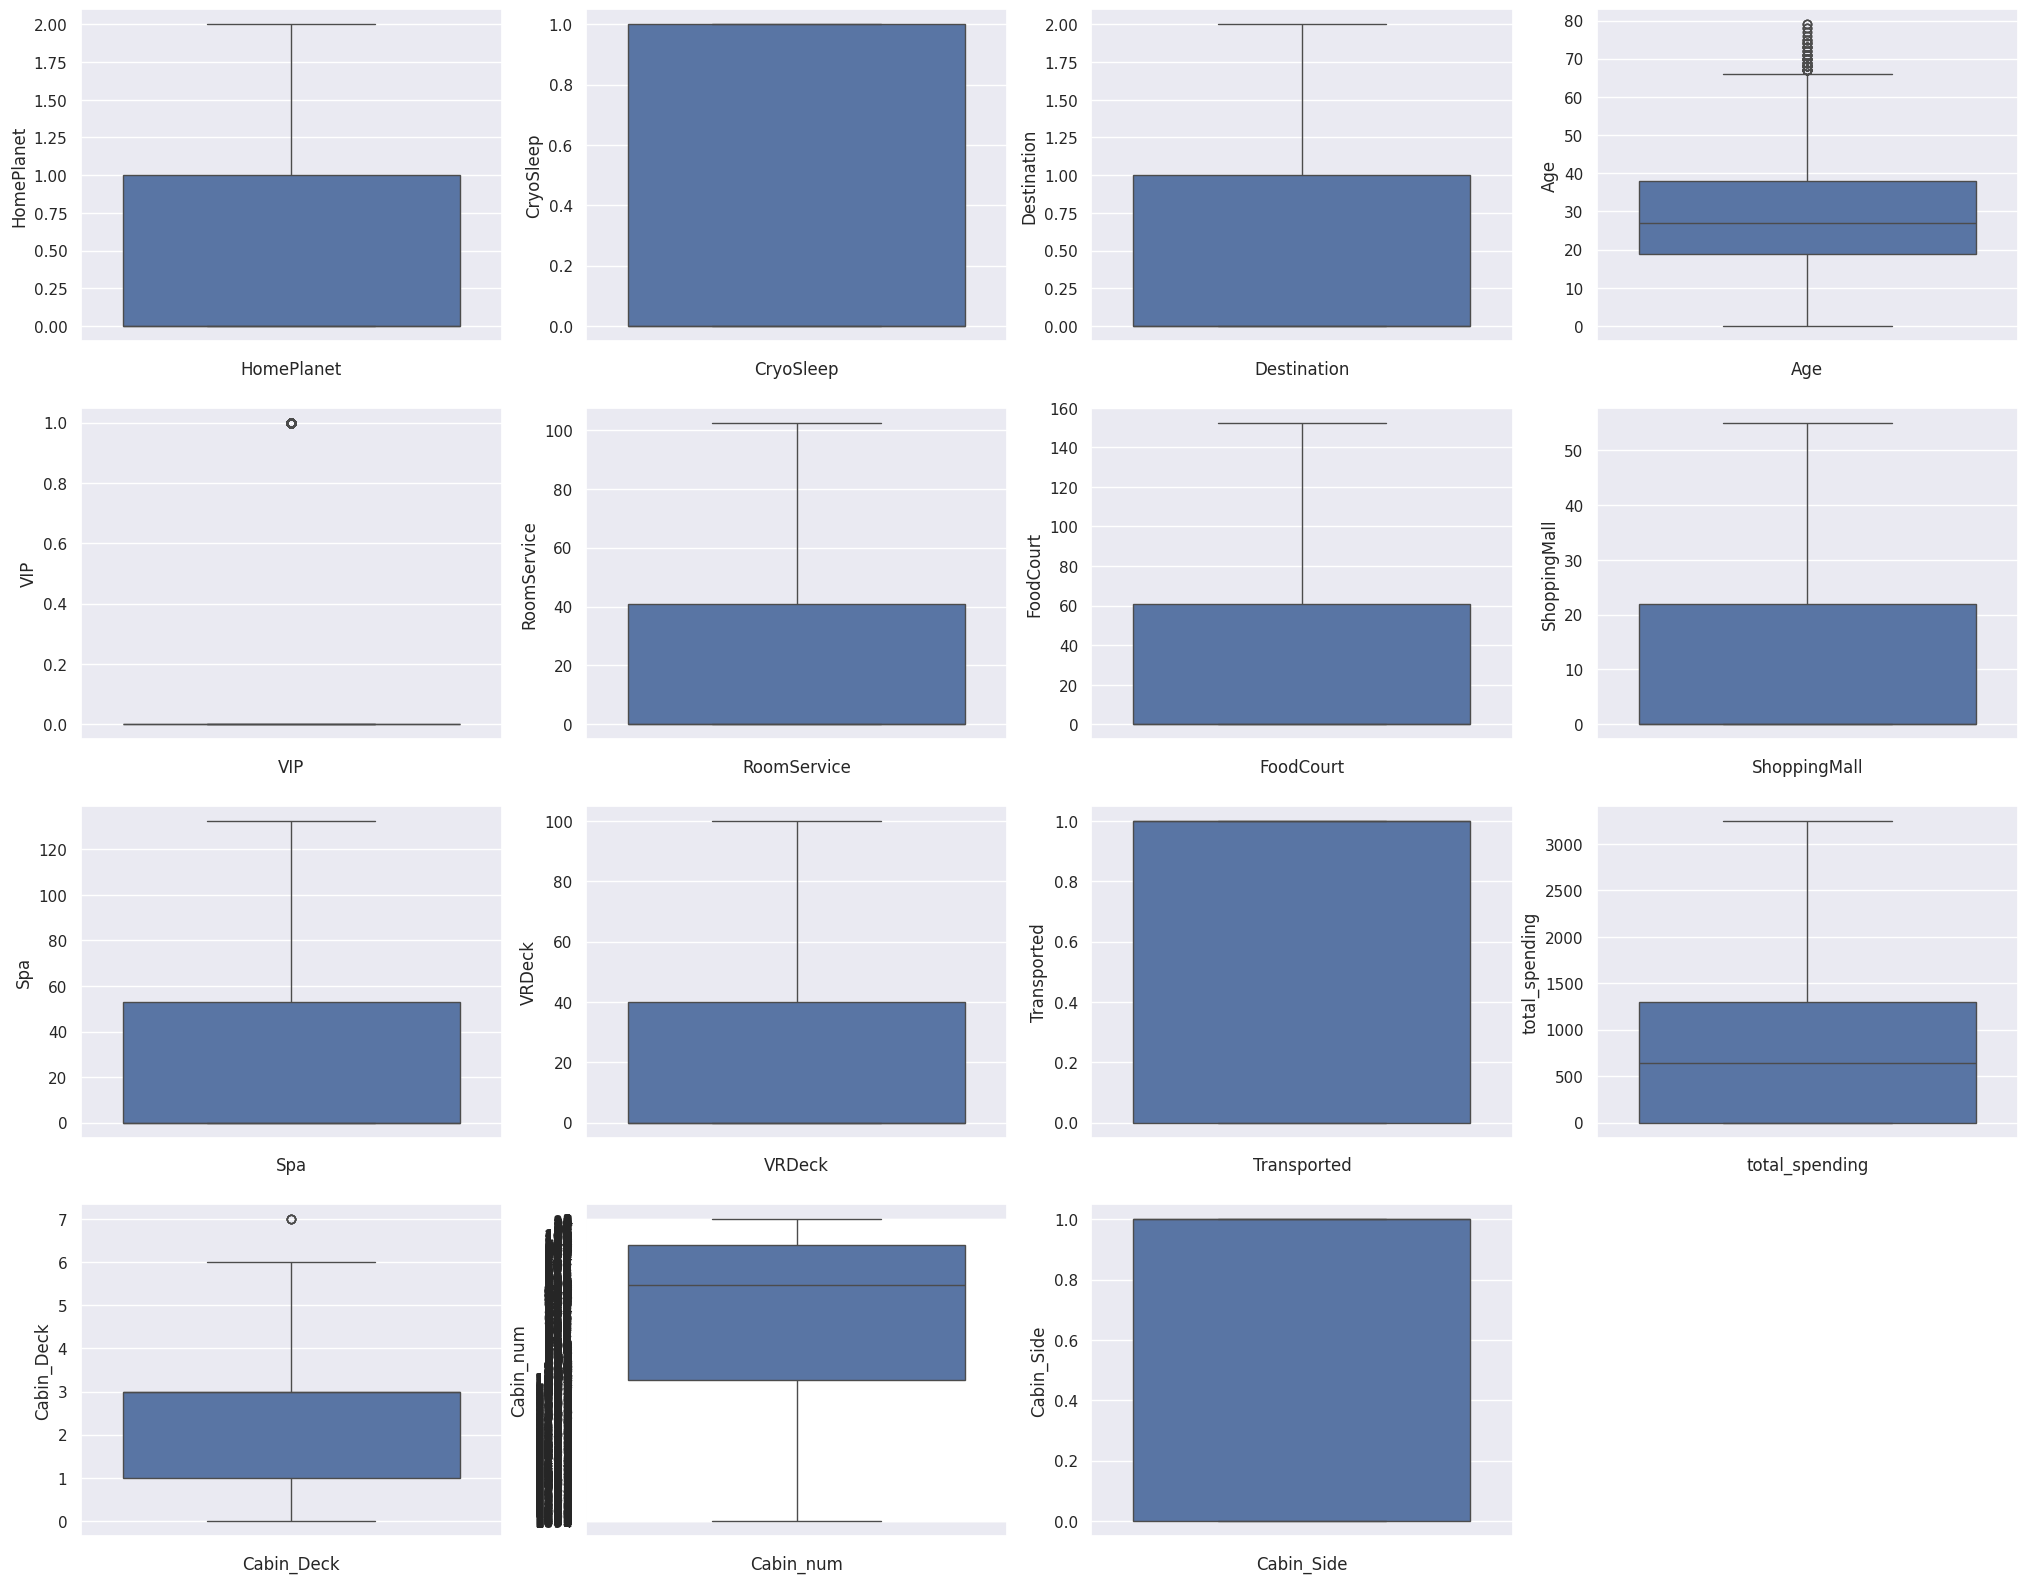

In [ ]:
fig = plt.figure(figsize=(25,25))
counter = 0
for col in df_train:
    sub = fig.add_subplot(5,4,counter+1)
    g = sns.boxplot(data=df_train[col])
    plt.xlabel(col)
    counter = counter + 1

## Applying a logarithmic transformation to the features.

In [ ]:
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_train['total_spending'] = df_train['RoomService'] + df_train['FoodCourt'] + df_train['ShoppingMall'] +\
df_train['Spa'] + df_train['VRDeck']

df_train = np.log(df_train[[col]])

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


#Modeling  

In [ ]:
X = df_train.drop("Transported", axis=1).values
y = df_train["Transported"].values

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((6954, 14), (6954,), (1739, 14), (1739,))

### In order to scale the data, the minmax method has been used only on train data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lg = LogisticRegression(max_iter=2000)
lg.fit(X_train,y_train)
lg_pred_score = lg.score(X_test_scaled ,y_test)
lg_pred_score

0.6026451983898793

### By applying cross validation, we can see that the accuracy of the model has increased.

In [ ]:
lg = LogisticRegression(max_iter=2000)
pipeline = make_pipeline(StandardScaler(), lg)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10)
mean_cv_score = cv_scores.mean()
print("Mean cross validation score:", mean_cv_score)

Mean cross validation score: 0.7648879517075995


#Model without scaling, feature engineering, removal of visible outliers and cross validation which is lower than the previous mode of accuracy.

In [ ]:
X = df_train_0.drop("Transported", axis=1).values
y = df_train_0["Transported"].values

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((6954, 14), (6954,), (1739, 14), (1739,))

In [ ]:
lg = LogisticRegression(max_iter=2000)
lg.fit(X_train,y_train)
lg_pred_score = lg.score(X_test_scaled ,y_test)
lg_pred_score

0.6026451983898793